In [106]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, VectorIndexer, Normalizer
from pyspark.ml.linalg import VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, BinaryLogisticRegressionSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

%matplotlib inline
plt.style.use('ggplot')

%reload_ext autoreload
%autoreload 2

# store path to notebook
PWD = !pwd
PWD = PWD[0]

# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## Setting up the toy dataset

In [2]:
# load the data
# Define the schema prior to loading the data
schema = StructType([StructField("label", IntegerType(), True),
                     StructField("I1", IntegerType(), True),
                     StructField("I2", IntegerType(), True),
                     StructField("I3", IntegerType(), True),
                     StructField("I4", IntegerType(), True),
                     StructField("I5", IntegerType(), True),
                     StructField("I6", IntegerType(), True),
                     StructField("I7", IntegerType(), True),
                     StructField("I8", IntegerType(), True),
                     StructField("I9", IntegerType(), True),
                     StructField("I10", IntegerType(), True),
                     StructField("I11", IntegerType(), True),
                     StructField("I12", IntegerType(), True),
                     StructField("I13", IntegerType(), True),
                     StructField("C1", StringType(), True),
                     StructField("C2", StringType(), True),
                     StructField("C3", StringType(), True),
                     StructField("C4", StringType(), True),
                     StructField("C5", StringType(), True),
                     StructField("C6", StringType(), True),
                     StructField("C7", StringType(), True),
                     StructField("C8", StringType(), True),
                     StructField("C9", StringType(), True),
                     StructField("C10", StringType(), True),
                     StructField("C11", StringType(), True),
                     StructField("C12", StringType(), True),
                     StructField("C13", StringType(), True),
                     StructField("C14", StringType(), True),
                     StructField("C15", StringType(), True),
                     StructField("C16", StringType(), True),
                     StructField("C17", StringType(), True),
                     StructField("C18", StringType(), True),
                     StructField("C19", StringType(), True),
                     StructField("C20", StringType(), True),
                     StructField("C21", StringType(), True),
                     StructField("C22", StringType(), True),
                     StructField("C23", StringType(), True),
                     StructField("C24", StringType(), True),
                     StructField("C25", StringType(), True),
                     StructField("C26", StringType(), True)])


In [3]:
# Load toy data into dataframe
toy_df = spark.read.parquet("toyData/*.parquet")

In [4]:
# Just some code to get only the numeric numbers for training. Won't be using this for the official notebook
toy_rdd = toy_df.rdd.map(tuple)
toy_RDD = toy_rdd.map(lambda line: (line[0],(line[1:14]))).cache()

In [5]:
assembler = VectorAssembler(
    inputCols=['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13'],
    outputCol="features")

toy_df_transformed = assembler.transform(toy_df)
toy_df_transformed = toy_df_transformed.select('features','label')
pd.DataFrame(toy_df_transformed.take(30), columns=toy_df_transformed.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
features,"[1.0, 17.0, 3.0, 6.0, 5.0, 6.0, 1.0, 5.0, 6.0,...","[0.0, 23.0, 47.0, 6.0, 13044.0, 2546.0, 0.0, 7...","[-999.0, 0.0, 1.0, 2.0, 20.0, -999.0, 0.0, 2.0...","[0.0, 3.0, 13.0, 1.0, 2940.0, 83.0, 1.0, 16.0,...","[1.0, 0.0, 5.0, 3.0, 171.0, 34.0, 3.0, 34.0, 6...","[-999.0, -1.0, -999.0, -999.0, 2975.0, 1.0, 14...","[-999.0, 2.0, 1.0, 3.0, 3031.0, 76.0, 1.0, 3.0...","[1.0, 4.0, 19.0, 17.0, 36.0, 7.0, 6.0, 22.0, 9...","[-999.0, -1.0, -999.0, -999.0, 8740.0, 12.0, 1...","[-999.0, 0.0, 7.0, 18.0, 3424.0, 22.0, 1.0, 21...",...,"[-999.0, 1.0, 3.0, 3.0, 109391.0, -999.0, 0.0,...","[0.0, 0.0, 2.0, 3.0, 1344.0, 5.0, 30.0, 7.0, 3...","[0.0, 68.0, 16.0, 3.0, 3735.0, 64.0, 1.0, 3.0,...","(-999.0, 0.0, 16.0, 8.0, 0.0, -999.0, 0.0, 7.0...","[-999.0, 1.0, 4.0, 4.0, 1837.0, 9.0, 2.0, 4.0,...","[0.0, 0.0, 4.0, -999.0, 1573.0, 42.0, 14.0, 8....","[5.0, 297.0, 5.0, 3.0, 8.0, 1.0, 34.0, 3.0, 14...","[-999.0, 1.0, 4.0, 2.0, 66163.0, -999.0, 0.0, ...","[-999.0, -1.0, 17.0, 6.0, 31979.0, 94.0, 1.0, ...","[-999.0, 31.0, 1.0, -999.0, 28527.0, -999.0, 0..."
label,0,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


### Titanic Data

In [117]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data=pd.read_csv('titanic_train.csv')
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data.drop(['Name','Age','Ticket','Fare','Cabin','PassengerId'],axis=1,inplace=True)
data['Embarked'].fillna(0,inplace=True)

train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

cols = train_X.columns
scaler = preprocessing.StandardScaler().fit(train[cols])
train[cols] = scaler.transform(train[cols]) 
test[cols] = scaler.transform(test[cols]) 

train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [119]:
# For Spark ML
training = spark.createDataFrame(train)
testing = spark.createDataFrame(test)

# vectorize features
training = VectorAssembler(inputCols=["Pclass", "Sex", "SibSp","Parch","Embarked","Age_band","Fare_cat"], outputCol="features").transform(training)
testing = VectorAssembler(inputCols=["Pclass", "Sex", "SibSp","Parch","Embarked","Age_band","Fare_cat"], outputCol="features").transform(testing)

lr = LogisticRegression(featuresCol="features", labelCol="Survived", maxIter=100, regParam=0.1, elasticNetParam=0)
# elasticNetParam: For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.

# Fit the model
lrModel = lr.fit(training)

In [120]:
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.3827632772606477,0.7511534778999844,-0.18501210699224013,0.03915059402928407,0.07504441253288871,-0.10084820705987878,0.27219387677927154]
Intercept: -0.5605990457370779


In [123]:
# For Home Grown Grad Descent

trainRDD = spark.createDataFrame(train).rdd.map(lambda x: (x[0],x[1:]))
testRDD = spark.createDataFrame(test).rdd.map(lambda x: (x[0],x[1:]))

wInit = np.random.uniform(0,1,8)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, wInit, nSteps = 500, regType='ridge', regParam = 0.1, verbose = False )

print(f"\n... trained {len(results[1])} iterations in {time.time() - start} seconds")
print("The final log loss is: {}".format(ridge_results[0][-1]))
print("The coefficients are: {}".format(ridge_results[1][-1][1:]))
print("The intercept is: {}".format(ridge_results[1][-1][0]))

/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)



... trained 500 iterations in 107.13280081748962 seconds
The final log loss is: nan
The coefficients are: [-15.48938862  11.36532917  -2.77870541   1.93793205  -4.28637041
   7.71489966  14.735553  ]
The intercept is: -4.687515481015949


## Setting up the toy dataset

In [57]:
toy_df = spark.createDataFrame(
    [(1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0),
     (1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0),
     (1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0),
     (1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0)],
    ["label", "feature1", "feature2", "feature3"])

In [98]:
toy_rdd = toy_df.rdd.map(tuple)
toy_RDD = toy_rdd.map(lambda line: (line[0],np.array(line[1:4]))).cache()
toy_RDD.collect()

[(1.0, array([1, 0, 1])),
 (1.0, array([1, 0, 1])),
 (0.0, array([0, 1, 0])),
 (1.0, array([1, 0, 1])),
 (1.0, array([1, 0, 1])),
 (0.0, array([0, 1, 0])),
 (1.0, array([1, 0, 1])),
 (1.0, array([1, 0, 1])),
 (0.0, array([0, 1, 0])),
 (1.0, array([1, 0, 1])),
 (1.0, array([1, 0, 1])),
 (0.0, array([0, 1, 0]))]

In [101]:
# part e - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    
    featureMeans = dataRDD.map(lambda x: x[1]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[1]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: (x[0], (x[1]-featureMeans)/featureStdev))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [102]:
normed_RDD = normalize(toy_RDD).cache()

toy_RDD will be the RDD used to train a logistic regression using the gradient descent method.

In [103]:
assembler = VectorAssembler(
    inputCols=["feature1", "feature2", "feature3"],
    outputCol="features")
toy_df_transformed = assembler.transform(toy_df)
toy_df_transformed = toy_df_transformed.select('features','label')
pd.DataFrame(toy_df_transformed.take(30), columns=toy_df_transformed.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
features,"[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]"
label,1,1,0,1,1,0,1,1,0,1,1,0


toy_df_transformed will be the dataframe used to train a logistic regression using Spark ML's LogisticRegression() function

## Log Loss

In [61]:
def LogLoss(dataRDD, W):
    """
    Compute the Log Loss of our model.
    Args:
        dataRDD - each record is a tuple of (y, features_array)
        W       - (array) model coefficients
    """
    # Add 1 to the front of the predictors array
    # Note that the b value has to be added to the front of our theta array
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1])))

    def LogLossPerRow(line):
        # Calculate the log loss for each row of the data in parallel
        actual_y, features = line
        predicted_y = np.dot(np.transpose(W),features)
        prob = 1.0/(1.0 + np.exp(-1.0*predicted_y))
        # Output is -[ylog(prob) + (1-y)log(1-prob)]
        yield -1.0*(actual_y*np.log(prob) + (1-actual_y)*np.log(1-prob))
    
    loss = augmentedData.flatMap(LogLossPerRow).mean()

    return loss

Now lets test our LogLoss function by setting b to the mean of the our label values and all our predictors to 0.

In [62]:
# Calculate the mean of all our label values
meanQuality = toy_RDD.map(lambda x: x[0]).mean()
print(f"Mean: {meanQuality}")

Mean: 0.6666666666666666


In [9]:
# Set the baseline model so that b is the mean we calculated and all other features are 0
BASELINE = np.append([meanQuality],[0,0,0,0,0,0,0,0,0,0,0,0,0])
#BASELINE = np.append([meanQuality],[0,0,0])

In [12]:
# Compute the loss of the baseline model
assert len(BASELINE) == len(toy_RDD.take(1)[0][1]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {LogLoss(toy_RDD, BASELINE)}")

Baseline model loss: 0.7627299666264257


In [15]:
# Verify if our result is correct or not

# Count how many 1's and 0's we have in our label
m = toy_RDD.count()
ones = toy_RDD.map(lambda line: 1 if line[0] == 1 else 0).sum()
zeros = m - ones
print("There are {} ones and {} zeros in the label column of our dataset".format(ones, zeros))

# Calculate the LogLoss in our example case
loss = (ones*np.log(1/(1.0 + np.exp(-1.0*meanQuality))) + zeros*np.log(1.0 - 1.0/(1.0 + np.exp(-1.0*meanQuality))))/-m
print("The loss of the baseline model through manual calculation is {}".format(loss))

There are 6 ones and 19 zeros in the label column of our dataset
The loss of the baseline model through manual calculation is 0.7627299666264258


We see that the results of our LogLoss() function is correct.

## Gradient Descent

In [124]:
# This code calculates the 3 different gradients with and without regularization
# Then it updates the model (w) and outputs the new model
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (y, features_array)
        W       - (array) model coefficients with intercept at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, intercept still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1])))
    
    new_model = None

    def GradientPerRow(line):
        # Calculates -y(1- 1/ 1+ exp( -ywx))x for each row
        actual_y, features = line
        predicted_y = np.dot(np.transpose(W),features)
        prob = 1.0/(1.0 + np.exp(-1.0*predicted_y))
        yield (prob - actual_y)*features
        
    # Use the same way as before to find the first component of the gradient function
    grad = augmentedData.flatMap(GradientPerRow).mean()
    
    # Take out the bias stored in index 0 of W
    model = W[1:]
    
    # Figure out the regulation component
    if regType == None:
        pass
        
    elif regType == 'lasso':
        reg_comp = regParam*np.sign(model)
        # Update the gradient function by taking the regularization component into consideration
        grad = grad + np.append(0.0,reg_comp)
                
    elif regType == 'ridge':
        reg_comp = regParam*model
        # Update the gradient function by taking the regularization component into consideration
        grad = grad + np.append(0.0,reg_comp)
    
    new_model = W - (learningRate*grad)
    
    return new_model

In [53]:
# This code performs the Gradient Descent iterations 
def GradientDescent_wReg(trainRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, model_history = [], []
    
    # perform n updates & compute test and train loss after each update
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(LogLoss(trainRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {LogLoss(trainRDD, model)}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, model_history

In [125]:
# run 50 iterations
#meanQuality = toy_RDD.map(lambda x: x[0]).mean()
#BASELINE = np.append([meanQuality],[0,0,0,0,0,0,0,0,0,0,0,0,0])
#BASELINE = np.append([meanQuality],[0,0,0])
#BASELINE = np.append([1],[1,-1,1])

wInit = np.random.uniform(0,1,4)
start = time.time()
results = GradientDescent_wReg(toy_RDD, wInit, nSteps = 500, learningRate = 0.1, 
                                     regType='ridge', regParam = 0.1, verbose = False )
print(f"\n... trained {len(results[1])} iterations in {time.time() - start} seconds")
print("The final log loss is: {}".format(results[0][-1]))
print("The coefficients are: {}".format(results[1][-1][1:]))
print("The intercept is: {}".format(results[1][-1][0]))


... trained 500 iterations in 93.60545516014099 seconds
The final log loss is: 0.2083570093787418
The coefficients are: [ 0.92424552 -0.92883157  0.92487984]
The intercept is: -0.023986745276121414


In [111]:
lr = LogisticRegression(maxIter=50, regParam=0.1, standardization=True, fitIntercept=True, elasticNetParam=0.0)
lrModel = lr.fit(toy_df_transformed)

In [112]:
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [1.6026464110841647,-1.602646356365978,1.6026464110841647]
Intercept: -0.4228085161634782


In [115]:
coef = lrModel.coefficients
rhs = np.dot(coef, [0,1,0]) + lrModel.intercept
1/(1+np.exp(-1.0*rhs))

0.27789688952282793

In [118]:
coef = results[1][-1][1:]
intercept = results[1][-1][0]
rhs = np.dot(coef, [1,0,1]) + intercept
1/(1+np.exp(-1.0*rhs))

0.9667723968574894

In [68]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

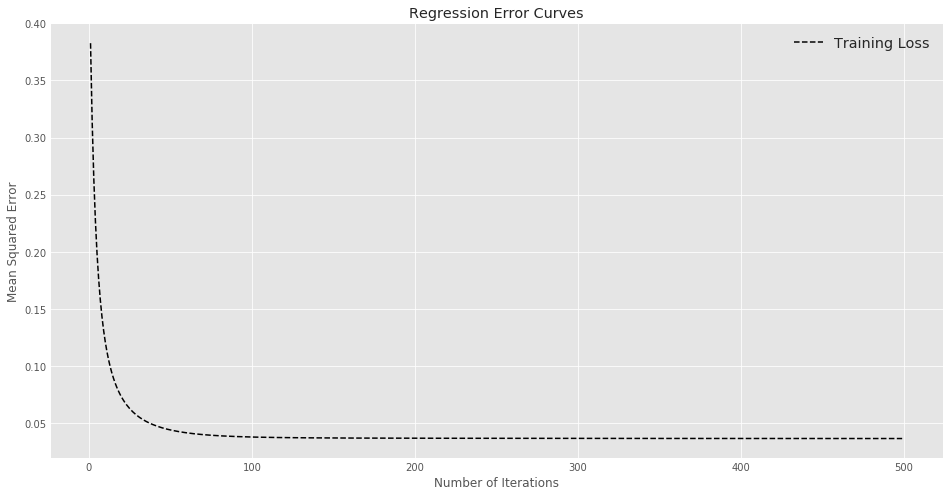

In [74]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, models = results
plotErrorCurves(trainLoss, title = 'Regression Error Curves' )

In [71]:
x_train = pd.DataFrame(toy_df.take(9), columns=['label','feature1','feature2','feature3']).iloc[:,1:]
y_train = pd.DataFrame(toy_df.take(9), columns=['label','feature1','feature2','feature3']).iloc[:,0]

from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(penalty = 'l2',fit_intercept = True,max_iter= 500,C=10, solver='saga' )
logisticRegr.fit(x_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
logisticRegr.coef_

array([[ 1.99827187, -2.00749903,  1.99827187]])

In [73]:
logisticRegr.intercept_

array([-0.62930163])